# EDA

## Imports

In [1]:
# first we add the root path
import sys

sys.path.append("../..")

In [2]:
import datetime
import yaml
import os

import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from src.utils.data_processing import remove_outliers, add_province


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## Load Data

In [3]:
# csv_filename = "dataset.csv"
# df = pd.read_csv(f"../../data/{csv_filename}")
# df.head()

with open('../../src/config.yaml') as file:
    config = yaml.safe_load(file)

file_path = os.path.join(
    '../..',
    config['data_directory'],
    config['file_name']
)

features = config['features']  # feature columns
label = config['target_name']  # target label
save_dir = config['save_dir']  # dir to save output

df = pd.read_csv(file_path)

df.head()


,Date,Price,Total Volume,Total Boxes,Small Boxes,Large Boxes,XLarge Boxes,Region
0,3/25/2018,1.71,2321.82,2006.46,1996.46,10.00,0.0,Seoul
1,3/18/2018,1.66,3154.45,2580.60,2577.27,3.33,0.0,Seoul
2,3/11/2018,1.68,2570.52,2209.29,2209.29,0.00,0.0,Seoul
3,3/4/2018,1.48,3851.30,3242.98,3239.65,3.33,0.0,Seoul
4,2/25/2018,1.56,5356.63,4007.48,4007.48,0.00,0.0,Seoul


## Exploration

### Stats

At a glance, we can see all columns have a skewed distribution, especially our target column.

In [4]:
df.describe()

,Price,Total Volume,Total Boxes,Small Boxes,Large Boxes,XLarge Boxes
count,644.000000,6.470000e+02,6.480000e+02,648.000000,648.000000,648.000000
mean,6.533540,7.500591e+04,4.963935e+04,40598.748580,9032.257948,8.345370
std,118.516792,2.127440e+05,1.407772e+05,115044.249219,29633.321649,43.304003
min,1.010000,2.064900e+03,9.884500e+02,284.430000,0.000000,0.000000
25%,1.410000,9.168750e+03,6.724712e+03,4813.205000,14.322500,0.000000
50%,1.550000,1.772227e+04,1.186087e+04,9120.540000,622.720000,0.000000
75%,1.710000,4.117210e+04,2.915701e+04,25105.742500,3289.035000,0.000000
max,3003.000000,1.814930e+06,1.124622e+06,944572.500000,267818.310000,510.410000


Let's look at the unique regions (cities) where prices come from.

In [5]:
df.Region.unique()

array(['Seoul', 'Incheon', 'deagu', 'Anyang', 'Ulsan', 'Busan', 'Daejon',
       'Jeju', 'Gwangju', 'Gangeung', 'Pyeongchang', 'Andong', 'Asan',
       'Boryeong', 'Chungju', 'Geoje', 'Gimpo', 'Gongju', 'Gunpo',
       'Hanam', 'Jeonju', 'Suwon', 'Taebaek', 'Pyeongtaek', 'Yeoju',
       'Wonju', 'Sangju', 'Miryang', 'Suncheon', 'Iksan', 'Namwon',
       'Siheung', 'Tongyeong', 'Yangju', 'Yangsan', 'Donghae', 'Gyeongju',
       'Gyeryong', 'Gimje', 'Gwangmyeong', 'Icheon'], dtype=object)

### NA values

Most of the entries are filled except for a few columns, including `Price` and `Total Volume`.

In [6]:
df.isna().apply(lambda x: sum(x))

Date            0
Price           4
Total Volume    1
Total Boxes     0
Small Boxes     0
Large Boxes     0
XLarge Boxes    0
Region          0
dtype: int64

There's a total of 4 rows which have NA entries. We remove those rows and proceed.

In [7]:
# let's remove rows with na price values as well as total volume
na_ct = df.isna().apply(lambda x: sum(x), axis=1)
mask = ~na_ct.apply(lambda x: True if x > 0 else False)

df.shape, df[mask].shape

((648, 8), (644, 8))

In [8]:
df_nona = df[mask]
df_nona.shape

(644, 8)

### Outliers

As we saw earlier, the price column is heavly skewed and most likely has outliers. There's an extream right skew.

In [9]:
prices = df_nona[label]

price_min, price_max = prices.min(), prices.max()
price_median, price_mean = prices.median(), prices.mean()
price_std = prices.std()

print(f"Price range is [{price_min}, {price_max}]")
print(f"Price median: {price_median}")
print(f"Price mean: {price_mean}")
print(f"Price std dev: {price_std}")

# there's an extreme right skew in the data, probably due to an outlier

Price range is [1.01, 3003.0]
Price median: 1.55
Price mean: 6.533540372670807
Price std dev: 118.51679173984056


We can confirm the skew and existence of outliers plotting histogram as shown below.

<Axes: >

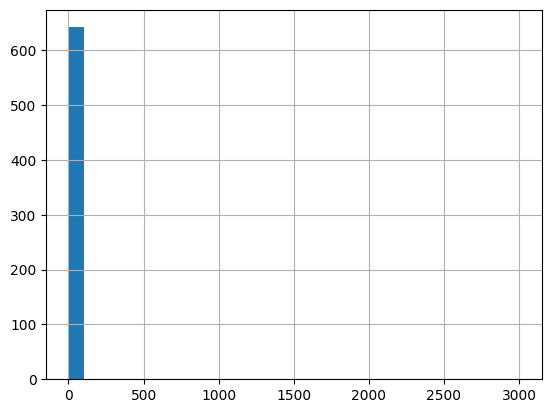

In [10]:
prices.hist(bins=30)

The max price is above 3000 while the median is 1.55. An extreme right skew.

In [11]:
round(prices.max())

3003

To validate this even further, we cound the number of elements inside equally sized bins.

In [12]:
def get_bin_count(
    df: pd.DataFrame,
    column: str,
    no_intervals: int = 6
):

    column_vals = df[column]
    
    col_min, col_max = column_vals.min(), column_vals.max()
    
    col_val_range = col_max - col_min
    interval = int(col_val_range // no_intervals)
    
    print(f"interval: {interval}")
    
    range_min, range_max = round(col_min), round(col_max) + interval
    bins = np.arange(range_min, range_max, interval)

    return column_vals.value_counts(bins=bins).sort_index()

In [13]:
get_bin_count(df_nona, label)

interval: 500


(0.999, 501.0]      643
(501.0, 1001.0]       0
(1001.0, 1501.0]      0
(1501.0, 2001.0]      0
(2001.0, 2501.0]      0
(2501.0, 3001.0]      0
(3001.0, 3501.0]      1
Name: count, dtype: int64

In [14]:
# let's find out which row this outlier corresponds to

df_nona[prices > 3000]  # this must be an error or very expensive kimchi

,Date,Price,Total Volume,Total Boxes,Small Boxes,Large Boxes,XLarge Boxes,Region
575,1/7/2018,3003.0,3788.91,2162.34,600.0,1562.34,0.0,Gwangmyeong


We remove outliers beyond 3 standard deviations an plot a histogram once more.

array([[<Axes: title={'center': 'Price'}>]], dtype=object)

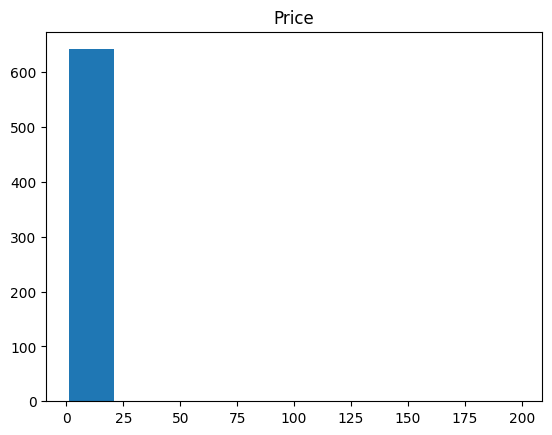

In [15]:
df_nona_noout = remove_outliers(df_nona, label)
df_nona_noout.hist(column=label, grid=False)

There's still an extreme right skew.

In [16]:
# seems we have more outliers here
prices = df_nona_noout[label]

prices.median(), prices.mean(), prices.std()  # we still see a heavy skew

(1.55, 1.8734059097978226, 7.789147038696363)

In [17]:
get_bin_count(df_nona_noout, label)

interval: 32


(0.999, 33.0]     642
(33.0, 65.0]        0
(65.0, 97.0]        0
(97.0, 129.0]       0
(129.0, 161.0]      0
(161.0, 193.0]      0
(193.0, 225.0]      1
Name: count, dtype: int64

We remove outliers 3 standard deviations away for a second time. Once, we do we finally get rid of the skew and the price distribution resembles a normal distribution

<Axes: xlabel='Price', ylabel='Count'>

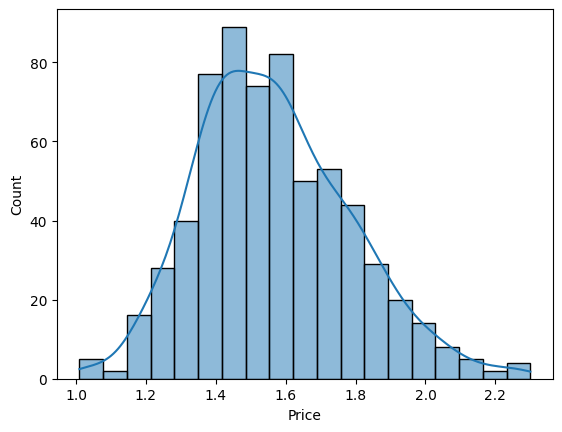

In [18]:
df_normal = remove_outliers(df_nona_noout, label)

sns.histplot(df_normal, x=label, kde=True)

### Date

Change date column to datetime if needed.

In [19]:
# convert date column to datetime
date_column = "Date"

date_entry = df_normal[date_column].iloc[0]
# convert if needed
if not isinstance(date_entry, pd._libs.tslibs.timestamps.Timestamp):
    df_normal.loc[:, date_column] = pd.to_datetime(df_normal[date_column])
# check
type(df_normal[date_column].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

### Plotting

Notice regions here correspond to major cities in South Korea.

In [20]:
# regions
df_normal["Region"].unique()

array(['Seoul', 'Incheon', 'deagu', 'Anyang', 'Ulsan', 'Busan', 'Daejon',
       'Jeju', 'Gwangju', 'Gangeung', 'Pyeongchang', 'Andong', 'Asan',
       'Boryeong', 'Chungju', 'Geoje', 'Gimpo', 'Gongju', 'Gunpo',
       'Hanam', 'Jeonju', 'Suwon', 'Taebaek', 'Pyeongtaek', 'Yeoju',
       'Wonju', 'Sangju', 'Miryang', 'Suncheon', 'Iksan', 'Namwon',
       'Siheung', 'Tongyeong', 'Yangju', 'Yangsan', 'Donghae', 'Gyeongju',
       'Gyeryong', 'Gimje', 'Gwangmyeong', 'Icheon'], dtype=object)

Let's choose the city of Icheon and see if there's any trends or patterns through the 3 months.

<Axes: xlabel='Date'>

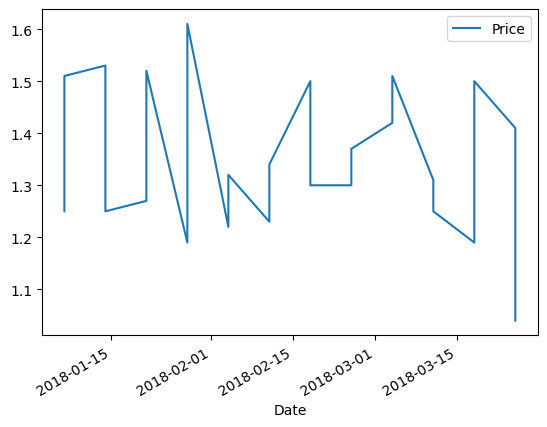

In [21]:
region = "Icheon"
df_region = df_normal[df_normal["Region"]==region]
df_region.plot(x='Date', y='Price')

As we can see above, the price experiences random fluctuations throughout the three months.

### Correlation

We wish to observe if there are any correlations between feature columns and price. However, we do observe there's greater fluctuation of prices for lower numeric feature values.

In [22]:
def plot_scatter(
    df: pd.DataFrame,
    x: str,
    y: str = label
):
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    sns.lmplot(x=x, y=y, data=df)
    plt.title("Scatter Plot with Linear fit")
    
    return sp.stats.pearsonr(df[x], df[y])
    

#### Price vs. Total Volume

PearsonRResult(statistic=-0.018294656461512838, pvalue=0.6435935870402283)

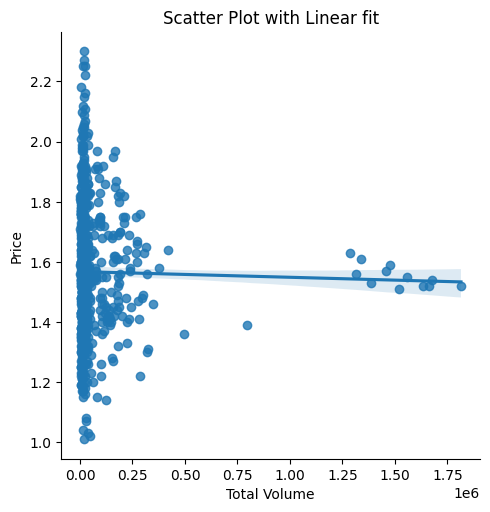

In [23]:
plot_scatter(df_normal, "Total Volume")

#### Price vs. Total Boxes

PearsonRResult(statistic=-0.03238792183814819, pvalue=0.41264279332307585)

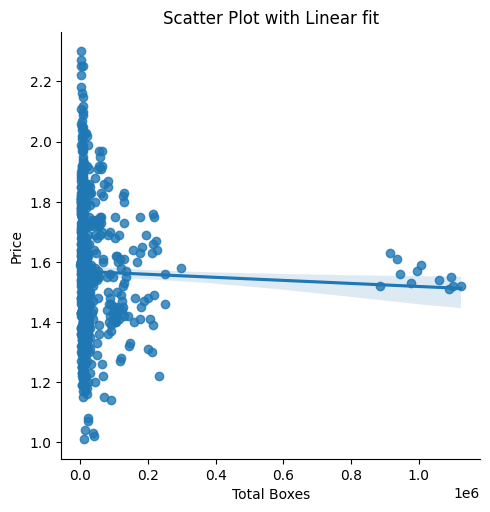

In [24]:
# any correlation between total boxes and price?
plot_scatter(df_normal, "Total Boxes")

#### Price vs. Small Boxes

PearsonRResult(statistic=-0.023546953030091616, pvalue=0.5514785899634123)

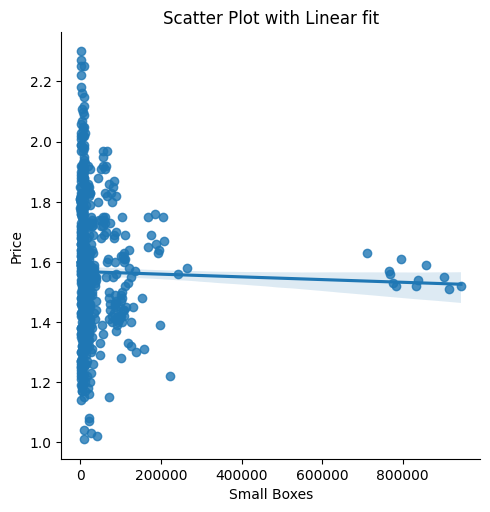

In [25]:
plot_scatter(df_normal, "Small Boxes")

#### Price vs. Large Boxes

PearsonRResult(statistic=-0.062410473254869744, pvalue=0.11415321576547612)

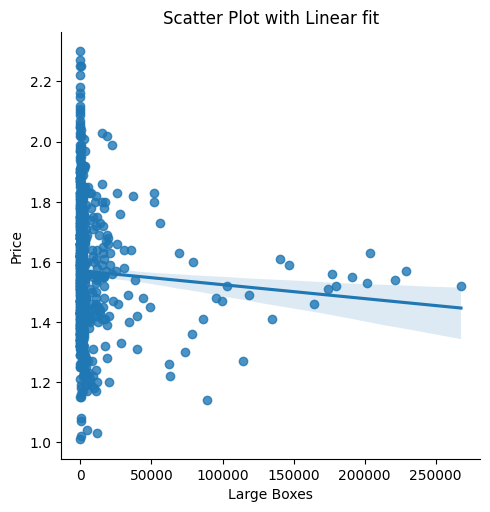

In [26]:
plot_scatter(df_normal, "Large Boxes")

#### Price vs. Day

We also check if there's a correlation between price and day of year.

In [27]:
# add day of year
def add_day(
    df: pd.DataFrame,
    date_col: str
):
    df.loc[:, "day"] = df[date_col].apply(lambda x: x.timetuple().tm_yday)
    

In [28]:
add_day(df_normal, "Date")

/var/folders/np/qvdkpcb52h56x5c95_krq3hw0000gn/T/ipykernel_6604/731658476.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "day"] = df[date_col].apply(lambda x: x.timetuple().tm_yday)


PearsonRResult(statistic=-0.07179383956920633, pvalue=0.06908041840271742)

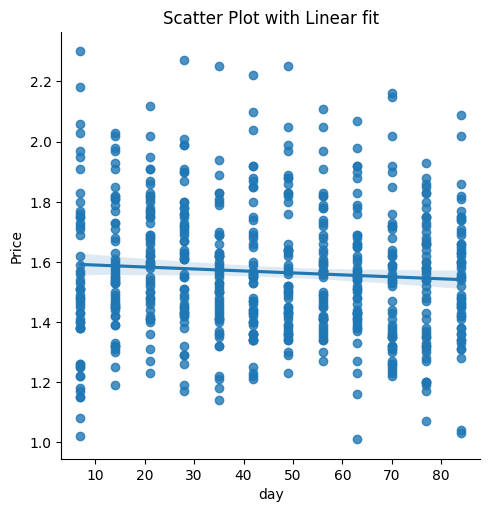

In [29]:
# and finally date
plot_scatter(df_normal, "day")

### Box plots

#### City

We explore if there's any distinction in price amongst different cities.

<Axes: title={'center': 'Price'}, xlabel='Region'>

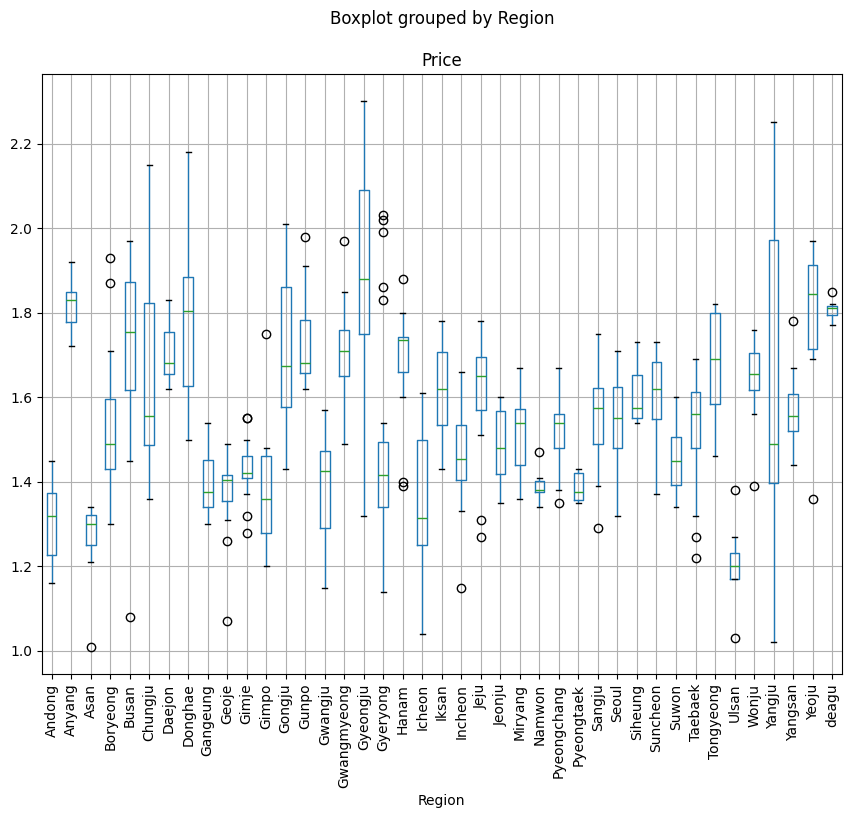

In [30]:
df_normal.boxplot(label, by="Region", rot=90)

#### Province

We map cities to province and plot box plots by province as well.

In [31]:
add_province(df_normal)

/Users/moseskim/Jobs/TRIDGE/price_prediction/src/notebooks/../../src/utils/data_processing.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Province"] = df[city_col].apply(lambda x: city_province_dict[x])


There are 9 provinces present.

In [32]:
df_normal["Province"].unique()

array(['Gyeonggi', 'North Gyeongsang', 'South Gyeongsang',
       'South Chungcheong', 'Jeju', 'Gangwon', 'North Chungcheong',
       'North Jeolla', 'South Jeolla'], dtype=object)

There's a clear distinction between provinces as we can see below. The inter-quartile range is smaller for some provinces compared to others.

<Axes: title={'center': 'Price'}, xlabel='Province'>

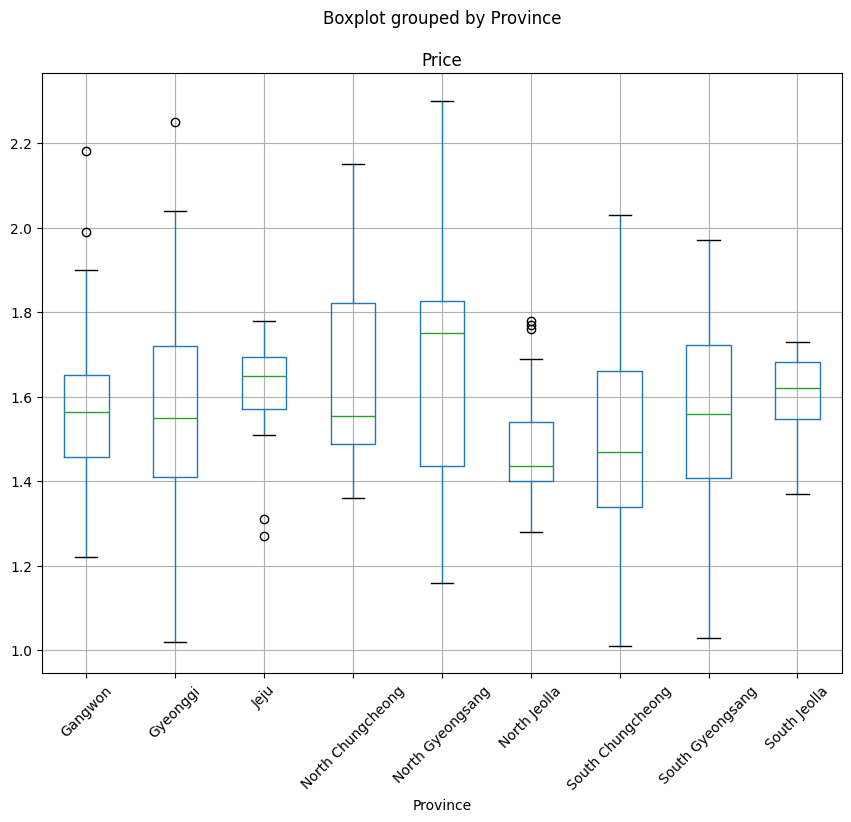

In [33]:
# plot box plot by province
df_normal.boxplot(label, by="Province", rot=45)

For training our models, we will include the province column as an additional feature.